In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import rawpy

In [3]:
import scipy.signal

In [9]:
import glob

In [4]:
def load_rgb(path, yrange=None, xrange=None):
    raw = rawpy.imread(path)
    rgb = raw.postprocess(demosaic_algorithm=rawpy.DemosaicAlgorithm.LINEAR,
                      output_bps=16, no_auto_bright=True, gamma=(2.5,3)).astype('float')

    if xrange and yrange:
        jupiter = rgb[yrange[0]:yrange[1],xrange[0]:xrange[1],:]
    else:
        jupiter = rgb
    return jupiter

def load_lum(path, yrange=None, xrange=None):
    jupiter = load_rgb(path, yrange, xrange)
    def lum(img):
        coeffs = [0.299, 0.587, 0.114 ]

        retval = np.zeros_like(img[:,:,0])
        for i, c_i in enumerate(coeffs):
            retval += c_i * img[:,:,i] # **2

        return retval # np.sqrt(retval)
    return lum(jupiter)

In [5]:
def find_target(x, tdim, downsample):
    # Implements a quick-and-dirty convolution with a tdim x tdim array of ones.
    
    if x.shape[0] <= tdim or x.shape[1] <= tdim:
        return None

    if 1 != downsample:
        ds_retval = find_target(x[::downsample, ::downsample], tdim/downsample, 1)
        return (downsample*ds_retval[0], downsample*ds_retval[1])
    
    sums = np.zeros((x.shape[0]-tdim, x.shape[1]-tdim))
    
    for d0 in range(tdim):
        for d1 in range(tdim):
            sums += x[d0:(d0-tdim),d1:(d1-tdim)]
            
    th = tdim/2
    
    maxloc = np.argmax(sums)
    maxind = np.unravel_index(maxloc, sums.shape)
    
    return (maxind[0]+th, maxind[1]+th)

In [7]:
def find_align(f0, f1,max_dx=30, max_dy=30):
    "Finds a rough alignment between two patches, searchs +/- the max_dx,max_dy ranges"
    
    # Make a little low-pass donut filter
    k = np.zeros((3,3))
    k += 1
    k[1,1] = 0
    k /= np.sum(k)

    # we compute the deltas both ways, then choose the minimum
    deltas01 = np.zeros((max_dy, max_dx))
    deltas10 = np.zeros((max_dy, max_dx))

    f0p = scipy.signal.convolve2d(f0, k, mode='same')
    f1p = scipy.signal.convolve2d(f1, k, mode='same')
    
    for dx in range(max_dx):
        for dy in range(max_dy):

            d = f1p[:-max_dy,:-max_dx] - f0p[dy:(dy-max_dy),dx:(dx-max_dx)]
            deltas10[dy,dx] = np.sqrt(np.sum(d*d))
            
            d = f0p[:-max_dy,:-max_dx] - f1p[dy:(dy-max_dy),dx:(dx-max_dx)]
            deltas01[dy,dx] = np.sqrt(np.sum(d*d))            

    min01 = np.min(deltas01)
    min10 = np.min(deltas10)
    
    if min01 < min10:
        return np.unravel_index(np.argmin(deltas01), deltas01.shape)
    
    minind = np.unravel_index(np.argmin(deltas10), deltas10.shape)
    return (-1*minind[0], -1*minind[1])

In [90]:
def extract_frame(x, t, margin, offset):
    i0 = t[0] + offset[0]
    i1 = t[1] + offset[1]
    
    return x[(i0-margin):(i0+margin),(i1-margin):(i1+margin)]

def load_stack(paths, tdim, margin, downsample=3):
    frames = []

    x = load_lum(paths[0])
    t = find_target(x, tdim, downsample)
    
    frames.append(extract_frame(x, t, margin, (0,0)))
    
    for p in paths[1:]:
        try:
            x = load_lum(p)
            t = find_target(x, tdim, downsample)
            rough_frame = extract_frame(x, t, margin, (0,0))
            o = find_align(frames[0], rough_frame)
            frame = extract_frame(x,t,margin,o)

            rms = np.sqrt(np.sum((frames[0]-frame)**2)/len(frame))

            #print "\tLoaded %s at -%s (t=%s) (RMS %0.2f)" % (p, o, t, rms)

            if False and (p == paths[1]):
                f2 = extract_frame(x,t,margin,(-o[0],-o[1]))
                rms2 = np.sqrt(np.sum((frames[0]-f2)**2)/len(f2))
                print "\tRMS+ = %0.1f, RMS- = %0.1f" % (rms, rms2)

            frames.append(frame.copy()) # copy to remove handle on raw x
        except Exception, e:
            print "EXCEPTION: %s -> %s" % (p, str(e))
    return frames

In [91]:
frames = load_stack(glob.glob("/home/jbm/Desktop/101CANON/buckets/1div50_5.7_3200_300.0/*.CR2")[:5], 20, 200)

In [92]:
j = np.zeros_like(frames[0])
divisor = 0
for f in frames:
    j += f
    divisor += 1.0
j /= divisor

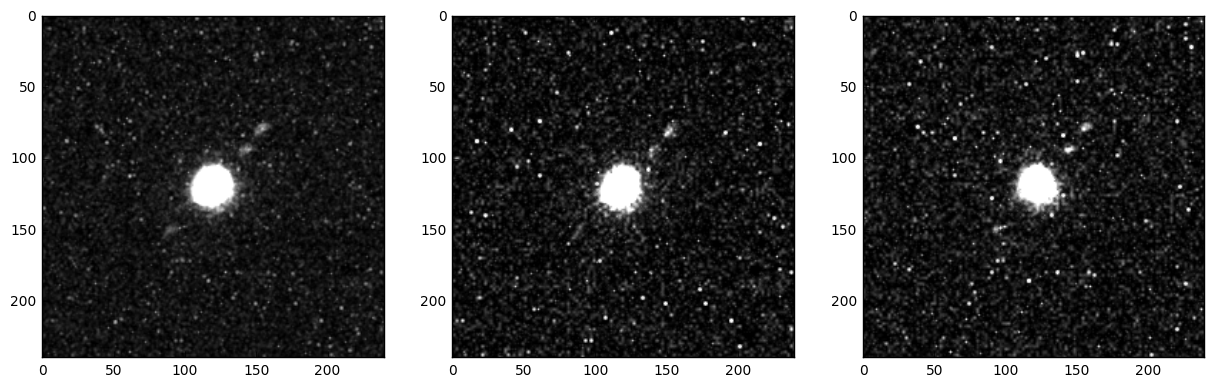

In [26]:
figure(figsize=(15,5))
subplot(1,3,1)
imshow(j, cmap=cm.gray, vmin=100, vmax=5000)
subplot(1,3,2)
imshow(frames[0], cmap=cm.gray, vmin=100, vmax=5000)
subplot(1,3,3)
imshow(frames[1], cmap=cm.gray, vmin=100, vmax=5000)

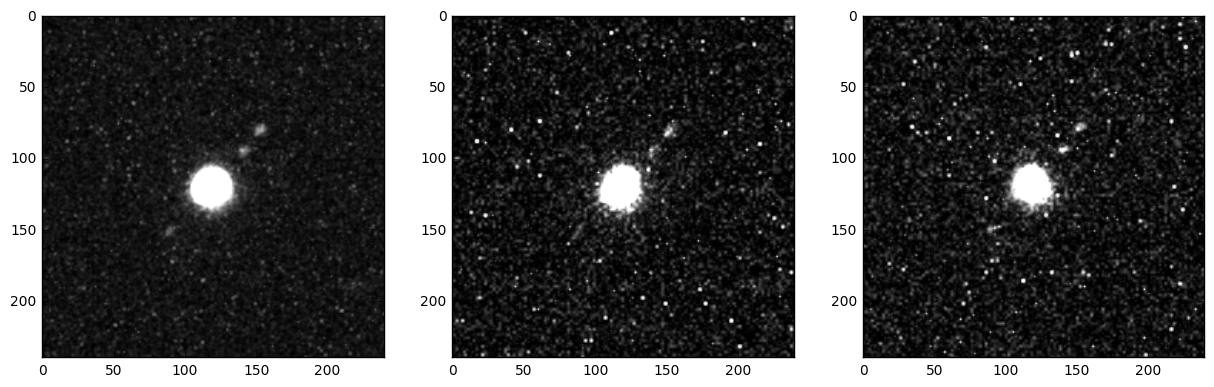

In [93]:
figure(figsize=(15,5))
subplot(1,3,1)
imshow(j, cmap=cm.gray, vmin=100, vmax=5000)
subplot(1,3,2)
imshow(frames[0], cmap=cm.gray, vmin=100, vmax=5000)
subplot(1,3,3)
imshow(frames[1], cmap=cm.gray, vmin=100, vmax=5000)

In [86]:
def cull_bad_frames(frames):
    if len(frames) < 5:
        return frames

    def _mse(f0,f1): # mean square error
        d = f1-f0
        return np.sum(d*d)
    
    l = len(frames)
    sm = np.zeros((l,l))

    for i in range(l):
        for j in range(i+1,l):
            s = _mse(frames[i], frames[j])
            sm[i,j] = s
            sm[j,i] = s
            
    total_scores = np.sum(sm,axis=0)
    central_frame = np.argmin(total_scores)
    
    scores = sm[central_frame]
    ss = sorted(scores)
    
    l = len(scores)
    iqr = ss[(l*3)/4] - ss[l/4]
    med = ss[l/2]
    tukey_upper_fence = med + 1.5*iqr

    retval = []
    for s,f in zip(scores, frames):
        if s > tukey_upper_fence:
            continue
        retval.append(f)
    return retval

In [83]:
def trivial_stack(frames):
    j = np.zeros_like(frames[0])
    divisor = 0
    for f in frames:
        j += f
        divisor += 1.0
    j /= divisor
    return j

In [103]:
# all_frames = {} # d => [ [frames]  ] # Memory hog!
n_frames = {} # d => # of frames
stacks = {} # d => stack
stacks_clean = {} # d => stack

for d in glob.glob("/home/jbm/Desktop/101CANON/buckets/*"):
    paths = glob.glob(d + "/*.CR2")
    if len(paths) < 3:
        print "Skipping short dir %s: %d" % (d, len(paths))
        continue
        
    print "******* LOADING %s: %d files" % (d, len(paths))
    frames = load_stack(paths, 20, 200)

    frames_clean = cull_bad_frames(frames)
    print "%s: CULLED %d to %d" % (d, len(frames), len(frames_clean))
    
                        
    # all_frames[d] = frames
    n_frames[d] = len(frames)
    stacks[d] = trivial_stack(frames)
    stacks_clean[d] = trivial_stack(frames_clean)

******* LOADING /home/jbm/Desktop/101CANON/buckets/1div20_5.7_3200_300.0: 8 files
/home/jbm/Desktop/101CANON/buckets/1div20_5.7_3200_300.0: CULLED 8 to 7
Skipping short dir /home/jbm/Desktop/101CANON/buckets/1div4_9.1_3200_300.0: 2
Skipping short dir /home/jbm/Desktop/101CANON/buckets/0.3_7.0_3200_300.0: 1
Skipping short dir /home/jbm/Desktop/101CANON/buckets/1div100_5.7_3200_300.0: 1
******* LOADING /home/jbm/Desktop/101CANON/buckets/1div4_5.7_1600_300.0: 29 files
/home/jbm/Desktop/101CANON/buckets/1div4_5.7_1600_300.0: CULLED 29 to 24
Skipping short dir /home/jbm/Desktop/101CANON/buckets/1div250_9.1_3200_300.0: 2
******* LOADING /home/jbm/Desktop/101CANON/buckets/1div4_8.0_3200_300.0: 7 files
/home/jbm/Desktop/101CANON/buckets/1div4_8.0_3200_300.0: CULLED 7 to 6
Skipping short dir /home/jbm/Desktop/101CANON/buckets/1div250_5.7_3200_300.0: 1
******* LOADING /home/jbm/Desktop/101CANON/buckets/1div50_9.1_3200_300.0: 13 files
/home/jbm/Desktop/101CANON/buckets/1div50_9.1_3200_300.0: CULL

In [104]:
len(stacks)

13

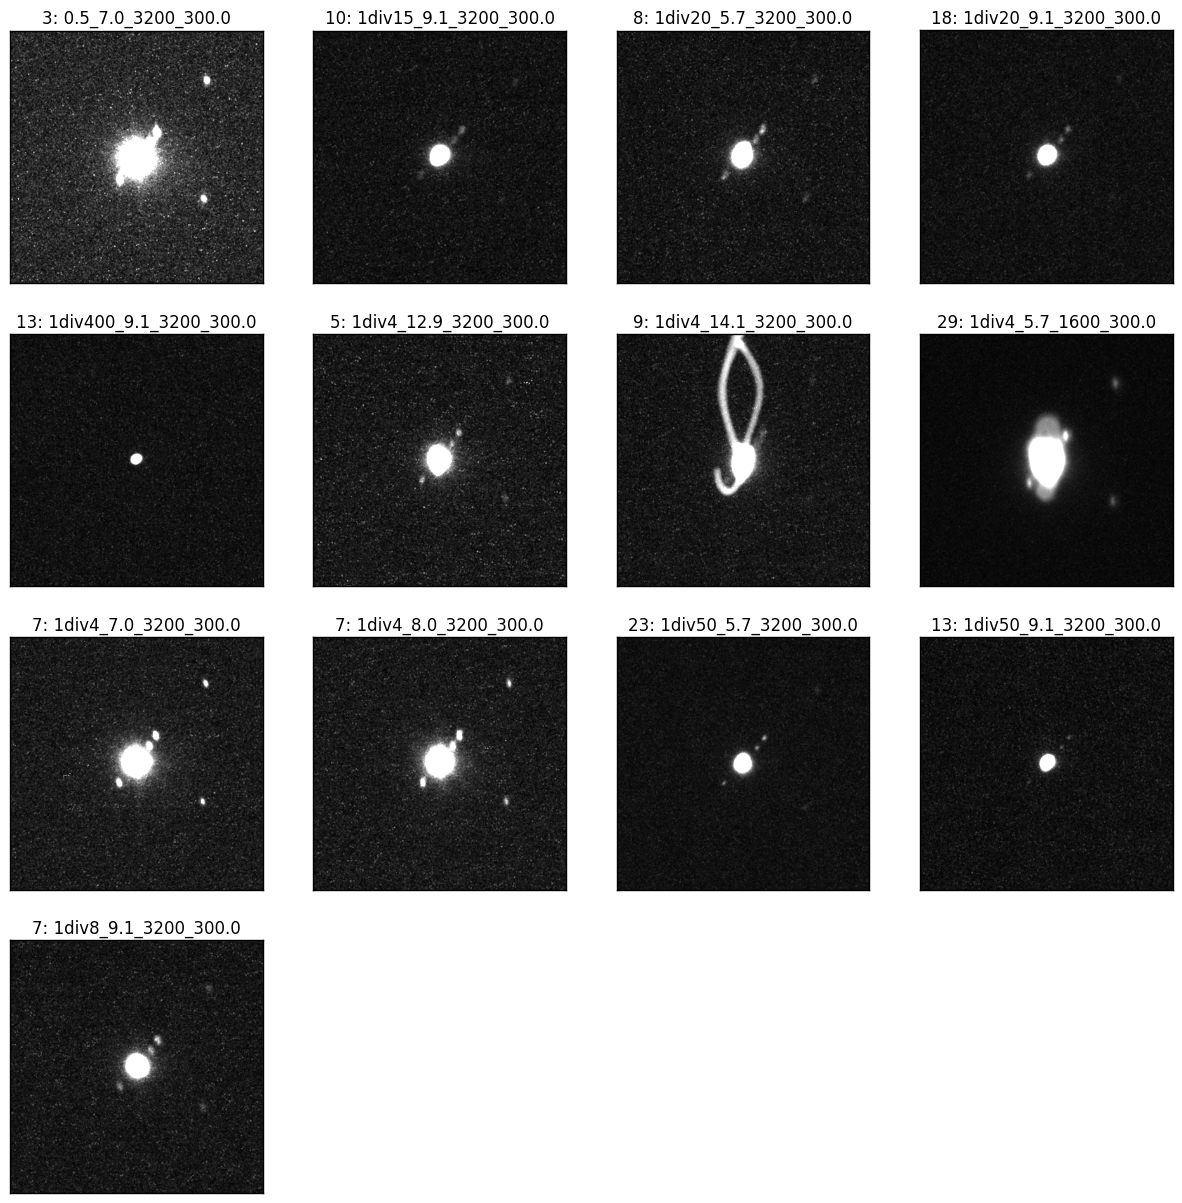

In [105]:
figure(figsize=(15,15))
ds = stacks.keys()
ds.sort()
for i,d_i in enumerate(ds):
    subplot(4,4,i+1)
    imshow(stacks[d_i], cmap=cm.gray, vmax=5000)
    ddisp = d_i.split('/')[-1]
    title("%d: %s" % (n_frames[d_i], ddisp))
    xticks([])
    yticks([])

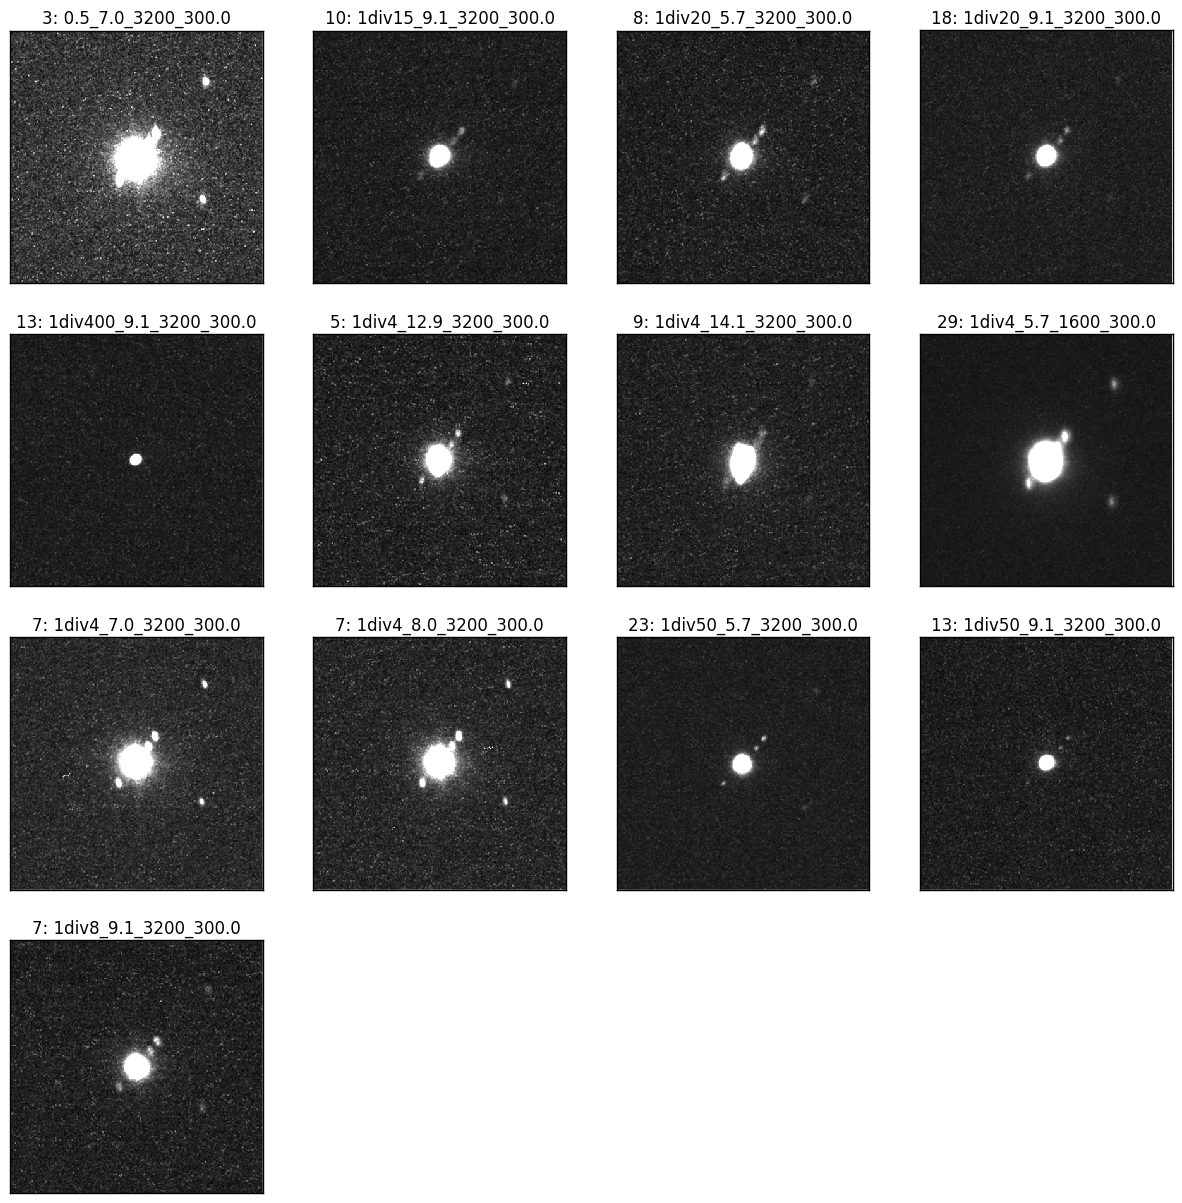

In [147]:
figure(figsize=(15,15))
ds = stacks.keys()
ds.sort()
for i,d_i in enumerate(ds):
    s = stacks_clean[d_i]
    subplot(4,4,i+1)
    vmin = np.percentile(s, 5)
    vmax = np.percentile(s, 99.5)
    imshow(s, cmap=cm.gray, vmin=0, vmax=4000, interpolation='none')
    ddisp = d_i.split('/')[-1]
    title("%d: %s" % (n_frames[d_i], ddisp))
    xticks([])
    yticks([])
    
savefig("20170515_jupiter_stacks_culled.jpg", facecolor='grey')

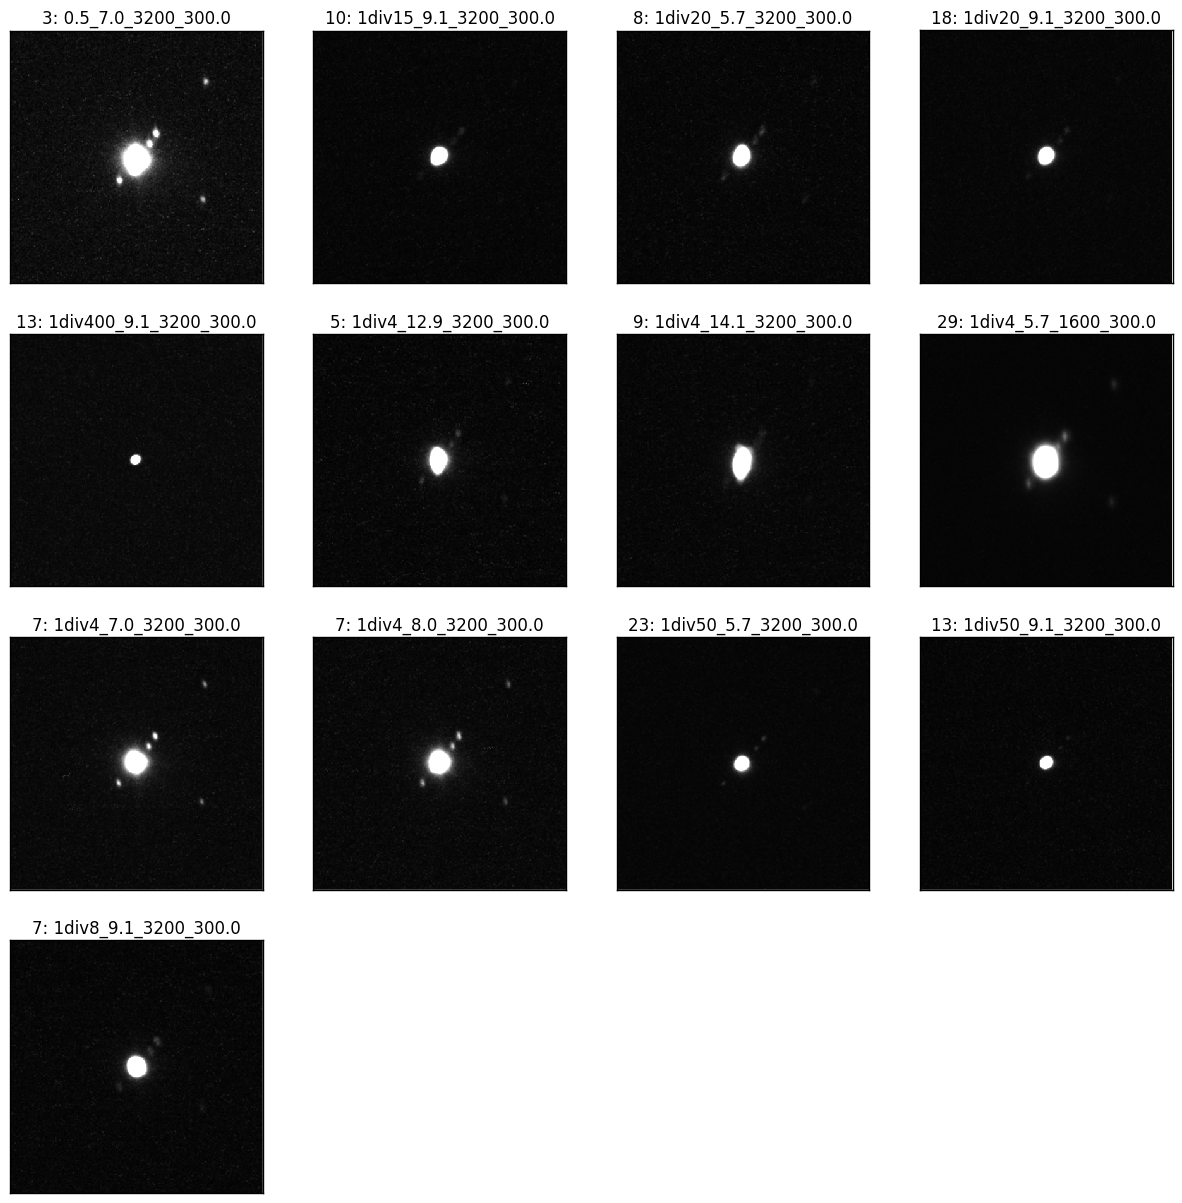

In [144]:
figure(figsize=(15,15))
ds = stacks.keys()
ds.sort()
for i,d_i in enumerate(ds):
    s = stacks_clean[d_i]
    subplot(4,4,i+1)
    vmin = np.max(s) * 0.0001 # np.percentile(s, 2)
    vmax = np.max(s)*0.25 # np.percentile(s, 99.5)
    imshow(s, cmap=cm.gray, vmin=vmin, vmax=vmax, interpolation='none')
    ddisp = d_i.split('/')[-1]
    title("%d: %s" % (n_frames[d_i], ddisp))
    xticks([])
    yticks([])

In [122]:
[ np.percentile(sc, 95) for sc in stacks_clean.values() ]

[1200.7874599999998,
 778.42246111111115,
 754.37756923076859,
 1356.6180833333324,
 876.84233999999958,
 1010.4867999999998,
 1077.5538374999996,
 1072.8032416666663,
 2342.2002833333327,
 822.92446999999959,
 735.09784047619041,
 802.81926249999742,
 1403.2773785714276]

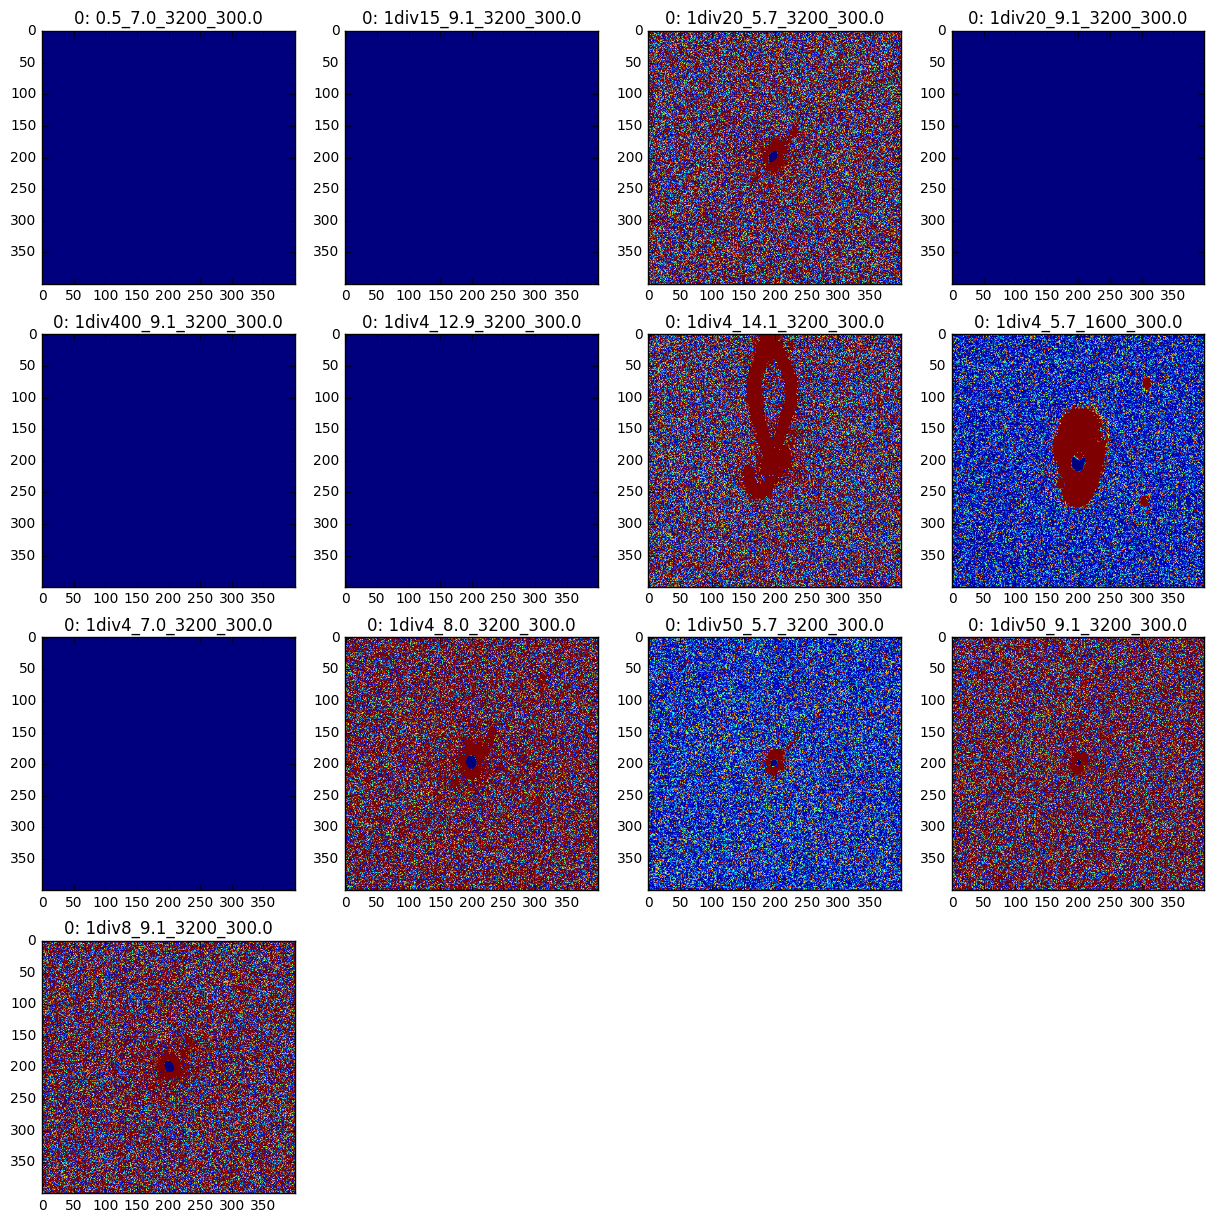

In [114]:
figure(figsize=(15,15))
ds = stacks.keys()
ds.sort()

for i,d_i in enumerate(ds):
    subplot(4,4,i+1)
    imshow((stacks[d_i] - stacks_clean[d_i])**2, vmax=2000)
    ddisp = d_i.split('/')[-1]
    title("%d: %s" % (0, ddisp))

In [108]:
import gca

ImportError: No module named gca

In [ ]:
gc.collect()

In [ ]:
del(all_frames)

In [ ]:
del(frames)

In [ ]:
j = stacks["/home/jbm/Desktop/101CANON/buckets/1div50_9.1_3200_300.0"]
imshow(j, cmap=cm.gray, vmax=3000)